# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Компания предоставила исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. Заказчику важны качество и скорость предсказания, а также время обучения.

**Цель проекта**

Построить наилучшую модель для прогнозирования рыночной стоимости автомобиля, основываясь на исторических данных с техническими характеристиками и комплектацией.

**Задачи**

1. Изучить предоставленный набор данных на наличие пропусков, дубликатов и артефактов.
2. Подготовить данные для анализа, обработать признаки, выявить зависимости между параметрами.
3. Исследовать разные модели и рассмотреть, как меняются показатели оценки в зависимости от примененной модели. Подобрать гиперпараметры.
4. Проверить модели на тестовой выборке, выявить наилучшую и проверить по итоговой метрике RMSE.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from timeit import default_timer as timer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from scipy import stats as st
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import warnings
warnings.filterwarnings("ignore")

### Изучение и корректировка исходных данных

Загрузим предоставленный файл и сохраним его в переменной autos.

In [2]:
autos = pd.read_csv('/datasets/autos.csv')
display(autos.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим, столбцы с какими типами данных имеются в датасете, и есть ли там пропуски.

In [3]:
print(autos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


В ряде столбцов имеются пропущенные значения. Также все столбцы с датами не имеют нужного типа. Например, в колонках DateCrawled,  DateCreated и LastSeen сейчас тип данных object, а в RegistrationYear и RegistrationMonth - int64.

Выведем основную статистику по столбцам и поищем в них неадекватные значения.

In [4]:
display(autos.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В датасете много ошибок. В столбце RegistrationYear минимальное значение - 1000 лет, максимальное - 9999 год, что в принципе не может быть. Такая же ситуация со значением 0 в колонке RegistrationMonth. Стоит проверить и колонку Power (минимально 0, максимально 20000).
Признак NumberOfPictures вообще какой-то бессмысленный, все значения равны 0. Эту колонку следует удалить.

Начнем с дат. Выведем диаграммы размаха по годам в разрезе каждого месяца.

Text(0, 0.5, 'Год')

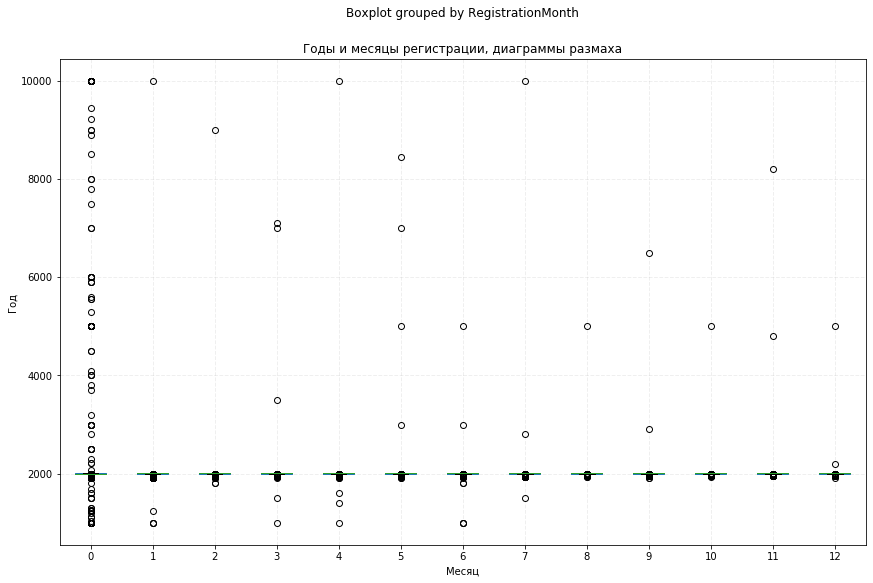

In [5]:
autos.boxplot(column='RegistrationYear', by='RegistrationMonth', figsize=(14,9))
plt.title('Годы и месяцы регистрации, диаграммы размаха')
plt.grid(alpha=0.2, linestyle='--', linewidth=1)
plt.xlabel('Месяц')
plt.ylabel('Год')

Выбросов очень много, они затрагивают значения тех годов, которые являются невероятными с точки зрения выпуска машин. Интересно, что большая часть выбросов приходится именно на нулевой месяц.

Посмотрим, какова доля пропусков по колонкам в датасете.

In [6]:
print(autos.isnull().mean())

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64


В колонках VehicleType и NotRepaired доля пропусков более 10%. Оба признака категориальные. Типов автомобильного кузова много, выбрать какой-то один для замены означает скорее всего не угадать. Проставлять значения, был ли автомобль в ремонте или нет тоже рисковая затея, поскольку одна пятая колонки может быть сильно исковеркана, а это довольно много. Обе колонки влияют на ценообразование, и, чтобы не искажать результаты, с этими данными придется расстаться.

In [7]:
print(len(autos))
autos = autos.dropna()
print(len(autos))

354369
245814


Теперь снова выведем наши боксплоты и посмотрим, что получилось.

Text(0, 0.5, 'Год')

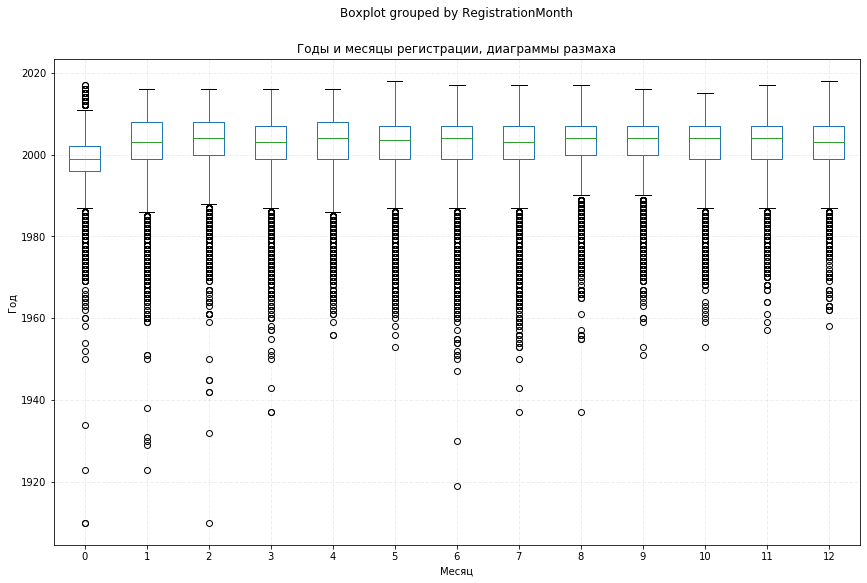

In [8]:
autos.boxplot(column='RegistrationYear', by='RegistrationMonth', figsize=(14,9))
plt.title('Годы и месяцы регистрации, диаграммы размаха')
plt.grid(alpha=0.2, linestyle='--', linewidth=1)
plt.xlabel('Месяц')
plt.ylabel('Год')

Интересно, что все невозможные значения RegistrationYear были удалены вместе с пропусками в других колонках. Это убеждает нас в правильности решения об удалении записей с пропусками, т.к. эти строки содержали в себе не одну ошибку, а, как минимум, несколько.

Тем не менее, аномальные значения все же остались. И если с 1910-1940 гг можно мириться (теоретически, кто-то может продавать автомобиль своего дедушки), то нулевой месяц нужно как-то обработать. 

Поскольку от месяца регистрации цена вряд ли будет сильно зависеть, но остальные данные в наблюдениях нам важны, заменим 0 на среднее или медианное значение. Для этого выведем среднее и медиану.

In [9]:
print(autos['RegistrationMonth'].mean())
print(autos['RegistrationMonth'].median())

6.179700912071729
6.0


Все эти значения указывают на июнь, поэтому заменим 0 на шестой месяц.

In [10]:
autos['RegistrationMonth'] = autos['RegistrationMonth'].replace(0, 6)

Посмотрим, что у нас получилось.

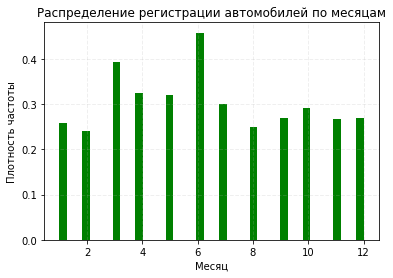

In [11]:
plt.hist(autos['RegistrationMonth'], density=True, bins=40, color='green', histtype='bar')
plt.title('Распределение регистрации автомобилей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Плотность частоты')
plt.grid(alpha=0.2, linestyle='--', linewidth=1)

Да, шестого месяца стало больше всех в данных, но все же пик не выглядит сильно вопиющим. Чтобы завершить предварительную обработку дат, сразу переведем все столбцы с датами в нужный формат.

In [12]:
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'], format = '%Y-%m-%dT%H:%M:%S')
autos['RegistrationYear'] = pd.to_datetime(autos['RegistrationYear'], format = '%Y').dt.year
autos['RegistrationMonth'] = pd.to_datetime(autos['RegistrationMonth'], format = '%m').dt.month
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'], format = '%Y-%m-%dT%H:%M:%S')
autos['LastSeen'] = pd.to_datetime(autos['LastSeen'], format = '%Y-%m-%dT%H:%M:%S')

Посмотрим, как распределяются наши данные по мощности двигателя.

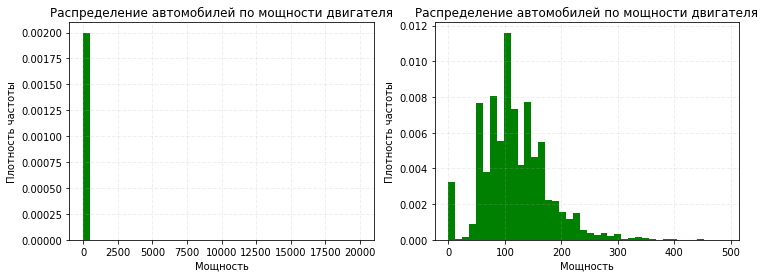

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

ax[0].hist(autos['Power'], density=True, bins=40, color='green', histtype='bar')
ax[0].set_title('Распределение автомобилей по мощности двигателя')
ax[0].set_xlabel('Мощность')
ax[0].set_ylabel('Плотность частоты')
ax[0].grid(alpha=0.2, linestyle='--', linewidth=1)

ax[1].hist(autos[autos['Power'] < 500]['Power'], density=True, bins=40, color='green', histtype='bar')
ax[1].set_title('Распределение автомобилей по мощности двигателя')
ax[1].set_xlabel('Мощность')
ax[1].set_ylabel('Плотность частоты')
ax[1].grid(alpha=0.2, linestyle='--', linewidth=1)

Оба графика раскрывают распределение одной и той же величины. Разница в масштабе. В первом случае на графике наблюдается высокий пик и больше ничего. Во втором распределение кажется более информативным. Также на втором графике виден пик в районе 0.

Все это говорит о том, что в данных существуют значения мощностей, которые выходят очень далеко за пределы основного распределения. Выведем пороговое значение для 99,9% всех мощностей.

In [14]:
print(autos['Power'].quantile(.999))

476.0


Отфильтруем из датасета все машины с мощностью 0 и мощностями, выходящими за 99,9% распределения.

In [15]:
print(autos.shape[0])
autos = autos.query('0 < Power < 476')
print(autos.shape[0])

245814
235947


Теперь проверим на нормальность категориальные признаки, нет ли в них странных значений.

In [16]:
print('Тип кузова', '\n', autos['VehicleType'].value_counts(), '\n')
print('Коробка передач', '\n', autos['Gearbox'].value_counts(), '\n')
print('Тип топлива', '\n', autos['FuelType'].value_counts(), '\n')
print('Торговая марка', '\n', autos['Brand'].value_counts(), '\n')
print('Наличие ремонта', '\n', autos['NotRepaired'].value_counts())

Тип кузова 
 sedan          69786
small          55670
wagon          49361
bus            22720
convertible    15783
coupe          11799
suv             9277
other           1551
Name: VehicleType, dtype: int64 

Коробка передач 
 manual    186817
auto       49130
Name: Gearbox, dtype: int64 

Тип топлива 
 petrol      155371
gasoline     76135
lpg           3741
cng            427
hybrid         168
other           56
electric        49
Name: FuelType, dtype: int64 

Торговая марка 
 volkswagen       50166
bmw              26529
opel             24869
mercedes_benz    22826
audi             21039
ford             16214
renault          10836
peugeot           7499
fiat              5992
seat              4763
skoda             4281
mazda             3801
citroen           3483
toyota            3475
nissan            3283
smart             3203
mini              2650
hyundai           2636
volvo             2395
mitsubishi        1940
honda             1861
kia               1798
al

В названиях категорий ошибок не выявлено.

Изучим целевой признак - цену.

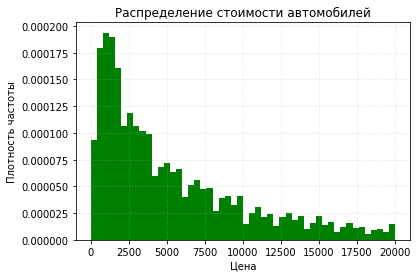

In [17]:
plt.hist(autos['Price'], density=True, bins=50, color='green')
plt.title('Распределение стоимости автомобилей')
plt.xlabel('Цена')
plt.ylabel('Плотность частоты')
plt.grid(alpha=0.2, linestyle='--', linewidth=1)

Распределение имеет сильную скошенность вправо, с длинным хвостом. В основном, цены на автомобили не слишком велики.
Поскольку нас интересует, как формируется цена на машины, то отфильтруем из набора данных все записи с целевым признаком, равным 0.

In [18]:
print(autos[autos['Price'] == 0]['Price'].count())
autos = autos[autos['Price'] != 0]
print(autos[autos['Price'] == 0]['Price'].count())

2915
0


Проверим датасет на наличие дубликатов.

In [19]:
print('Количество дубликатов в наборе данных: {}'.format(autos.duplicated().sum()))

Количество дубликатов в наборе данных: 4


Удалим их их набора.

In [20]:
autos = autos.drop_duplicates()

### Анализ корреляций

Выведем корреляционную матрицу и посмотрим, какие зависимости есть между признаками.

In [21]:
display(autos.corr().style.background_gradient(cmap='coolwarm').set_precision(2))

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1,0.56,0.5,-0.41,0.013,nan,0.058
RegistrationYear,0.56,1,0.15,-0.37,-0.00036,nan,0.03
Power,0.5,0.15,1,0.12,0.02,nan,0.05
Kilometer,-0.41,-0.37,0.12,1,0.0039,nan,-0.0099
RegistrationMonth,0.013,-0.00036,0.02,0.0039,1,nan,-0.0065
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.058,0.03,0.05,-0.0099,-0.0065,nan,1


Как и ожидалось, наблюдается положительная корреляция между ценой, годом выпуска и мощностью двигателя, а также отрицательная корреляция между стоимостью и пробегом. Но иногда закономерности могут носить нелинейный характер, и в этом случае коэффициент корреляции может оказаться бесполезным показателем. 
Рассчитаем коэффициент ранговой корреляции Спирмена, он более устойчив к выбросам. Используем тот же код, только функции corr() передадим параметр method='spearman'.

In [22]:
display(autos.corr(method='spearman').style.background_gradient(cmap='coolwarm').set_precision(2))

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1,0.73,0.52,-0.39,0.019,nan,0.057
RegistrationYear,0.73,1,0.19,-0.45,-0.0075,nan,0.037
Power,0.52,0.19,1,0.13,0.021,nan,0.058
Kilometer,-0.39,-0.45,0.13,1,0.0037,nan,-0.016
RegistrationMonth,0.019,-0.0075,0.021,0.0037,1,nan,-0.0065
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.057,0.037,0.058,-0.016,-0.0065,nan,1


В целом, показатели не сильно изменились.

Попробуем выделить зависимости между ценой и категориальными признаками. Сначала посмотрим, как меняется цена в зависимости от вида кузова и типа коробки передач.

In [23]:
display(autos.pivot_table(index='VehicleType', columns='Gearbox', values='Price', aggfunc='mean').sort_values(by='auto', ascending=False))

Gearbox,auto,manual
VehicleType,,
suv,10661.575253,8840.220527
convertible,9171.484001,6909.065159
coupe,8938.106302,5917.070457
bus,7822.358812,5629.398679
wagon,7394.578939,4882.673736
sedan,7280.725036,4623.098048
other,6642.568182,3988.689681
small,4181.265128,3091.251649


Машины с автоматической коробкой передач ценятся больше, чем с механической. Также цена сильно варьируется в зависимости от типа кузова. 

Посмотрим на рейтинг автомобилей исходя из вида используемого топлива и наличия ремонта в истории. 

In [24]:
display(autos.pivot_table(index='FuelType', columns='NotRepaired', values='Price', aggfunc='mean').sort_values(by='no', ascending=False))

NotRepaired,no,yes
FuelType,,
hybrid,10620.367742,5354.166667
electric,8358.511111,4416.666667
gasoline,7576.231960,3760.703616
cng,5116.418605,2481.694444
petrol,4680.055045,1693.256038
lpg,4661.623344,2247.489320
other,4198.068182,866.666667


В соответствии с последними тенденциями развития технологий и заботе об экологии, больше всего ценятся гибриды и электрокары. Возможно, это связано также с тем, что сами по себе эти машины относительно новые, а недавний год выпуска ценится дороже старых автомобилей (за исключением раритетных экземпляров в хорошем состоянии для истинных ценителей и коллекционеров). Ожидаемо "битая" машина сильно теряет в цене (в среднем более чем в 2 раза) по сравнению с той, которая не попадала в автосервис вследствие поломки или аварии.

### Подготовка признаков

Поскольку категорий по каждому категориальному признаку (кроме наличия ремонта в анамнезе) у нас много, а логистическая регрессия далее рассматриваться не будет, применим для категориальных признаков кодирование по номеру категории (Ordinal Encoding).

In [25]:
encoder = OrdinalEncoder()
encoder.fit(autos[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])
autos[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']] = encoder.transform(autos[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])

Проверим, что у нас получилось.

In [26]:
display(autos.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3,2016-03-17 16:54:04,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,37.0,0.0,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,1.0,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0,2016-04-01,0,67112,2016-04-05 18:18:39
10,2016-03-26 19:54:18,2000,4.0,2004,1.0,105,10.0,150000,12,6.0,19.0,0.0,2016-03-26,0,96224,2016-04-06 10:45:34


Разделим датасет на обучающую и тестовую выборки. Тест составит 25% от всего набора данных.

In [27]:
autos_train, autos_test = train_test_split(autos, test_size=0.25, random_state=12345)

Далее из выборок выделим наборы обучающих признаков и целевой признак. Из обучающих и тестовых признаков исключим колонки PostalCode и NumberOfPictures, в них нет никакого смысла.

In [28]:
target_train = pd.DataFrame(autos_train, columns = ['Price'])
features_train = autos_train.drop(columns = ['Price', 'PostalCode', 'NumberOfPictures', 
                                             'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target_test = pd.DataFrame(autos_test, columns = ['Price'])
features_test = autos_test.drop(columns = ['Price', 'PostalCode', 'NumberOfPictures', 
                                           'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

print('train', features_train.shape, target_train.shape)
print('test', features_test.shape, target_test.shape)

train (174771, 10) (174771, 1)
test (58257, 10) (58257, 1)


Чтобы привести признаки к единому масштабу, стандартизируем их методом StandardScaler и выведем первые строки получившейся таблицы (тренировочные данные).

In [29]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(pd.DataFrame(features_train).head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
345461,-0.116160,1.299075,-1.951377,-0.334050,0.117596,-1.539990,-0.714483,0.713955,1.286002,-0.341757
168157,1.287189,-0.012603,0.512459,0.043098,0.652404,-0.729928,-0.412700,0.713955,-0.778867,-0.341757
265162,-0.116160,0.807196,-1.951377,0.759679,-1.360164,0.620176,-0.412700,-1.417919,-1.390680,-0.341757
214772,1.287189,-0.504482,0.512459,-0.051189,0.399074,0.620176,1.397999,0.713955,0.521235,-0.341757
134901,1.287189,-0.176563,0.512459,-0.899772,-0.923873,0.620176,0.794433,-1.417919,0.291805,-0.341757


### Вывод

В ряде столбцов обнаружены пропущенные значения, больше всего в колонке NotRepaired (порядка 20%). Причины появления NaN могут быть самые разные. Это может быть случайностью или умышленным действием. Продавец не поставил галочку (просто не обратил внимание на эту графу), т.к. машина в ремонте не была. Или же, наоборот, попала в аварию, а владелец решил это особо не афишировать в объявлении и предпочел не говорить ничего. Пропуски было решено удалить. Тем более, с удалением пропусков ушли все экстремальные годы (вроде 1000, 1001 или 9999 лет), что подтверждает верность выбранного решения. Артефакты в колонке месяца регистрации (значение 0) заменены на медианное значение 6, т.к. эта колонка не должна сильно повлиять на прогнозы, зато другие признаки в записях можно сохранить. 

Также из датасета были отфильтрованы все машины с мощностью 0 и мощностями, выходящими за 99,9% распределения. Чтобы не портить качество моделей и не занижать итоговую стоимость, из целевого признака были выведены все машины с ценой, равной 0.

Все столбцы с датами переведены в соответствующий формат даты. В наборе данных найдено всего 4 дубликата, они были удалены из датасета.

К категориальным признакам применено кодирование по номеру категории (Ordinal Encoding). При формировании наборов обучающих факторов из списка удалены колонки PostalCode и NumberOfPictures, как не представляющие прогнозной значимости.

## Обучение моделей

В проекте рассмотрено шесть моделей: линейная регрессия, дерево решений, случайный лес, стохастический градиентный спуск и две модели градиентного бустинга.

Оптимальные гиперпараметры будем подбирать с помощью функции GridSearchCV(). Поскольку перебирать гиперпараметры мы будем не один раз, объявим функцию для подбора этих гиперпараметров. На вход она будет принимать перечень параметров, тип модели, набор обучающих признаков и обучающий целевой признак.

Возвращать функция будет метрику RMSE (среднеквадратичную ошибку). Для расчета метрики напишем функцию select_mse и имплементируем ее в функцию подбора параметров модели. Количество подвыборок для кросс-валидации укажем 3 (cv=3). Это позволит, с одной стороны, объективнее оценить размер ошибки отдельно не выделяя валидационную выборку, а с другой - не очень большое количество подвыборок ускорит процесс подбора гиперпараметров.

In [30]:
select_mse = make_scorer(mean_squared_error, greater_is_better=False)

def select_params(params, model, features, target):
    mod = GridSearchCV(model, params, cv=3, scoring=select_mse)
    %time mod.fit(features, target)
    print('rmse:', ((((mod.best_score_)*(-1))**0.5).round(3)))
    print(mod.best_params_)

Поскольку кроме точности прогнозирования нам нужно еще оценить скорость работы модели, мы также будем фиксировать время отработки кода. Для удобства оценки вынесем все зафиксированное время обучения моделей в отдельную (заранее объявленную) переменную (словарь). Позже выведем эти данные в общую сравнительную таблицу для всех алгоритмов.

In [31]:
fit_time = {}

### Линейная регрессия

Первой моделью рассмотрим классическую линейную регрессию.

In [32]:
params = {}
select_params(params, LinearRegression(), features_train, target_train)

CPU times: user 543 ms, sys: 340 ms, total: 883 ms
Wall time: 846 ms
rmse: 2877.947
{}


Сохраним нашу модель для прогнозирования стоимости.

In [33]:
%%time
start= timer()
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
end = timer()
fit_time['Linear Regression'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

CPU times: user 80 ms, sys: 46.3 ms, total: 126 ms
Wall time: 174 ms


### Дерево решений

Рассмотрим дерево решений. Выведем rmse, какая получается, если не "докручивать" модель, а использовать гиперпараметры, установленные по умолчанию.

Используем нашу функцию для подбора параметров, т.к. она основана на кросс-валидации (нет необходимости проверять результат на валидационной выборке, позже используем сразу тестовую). Просто передадим ей пустые параметры.

In [34]:
# Wall time: 3.15 s
params = {}
select_params(params, DecisionTreeRegressor(random_state=12345), features_train, target_train)

Теперь попробуем подкрутить

In [35]:
# Wall time: 12.9 s
params = {'max_depth': range(4,10), 'min_samples_split': [2,4,6], 'min_samples_leaf': range(1,2,4)}
select_params(params, DecisionTreeRegressor(random_state=12345), features_train, target_train)

Качество модели улучшилось. Сохраним модель с подобранными гиперпараметрами.

In [36]:
start= timer()
model_dt = DecisionTreeRegressor(random_state=12345, max_depth=9, min_samples_split=6, min_samples_leaf=1)
%time model_dt.fit(features_train, target_train)
end = timer()
fit_time['Decision Tree'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

CPU times: user 457 ms, sys: 12 ms, total: 469 ms
Wall time: 503 ms


### Случайный лес

Теперь попробуем использовать для прогнозирования не одно дерево, а их ансамбль. Сначала применим гиперпараметры "из коробки", которые используются в алгоритме по умолчанию.

In [37]:
# Wall time: 20.5 s
params = {}
select_params(params, RandomForestRegressor(random_state=12345), features_train, target_train)

Попробуем поменять гиперпараметры модели и посмотрим, удастся ли улучшить результат. Для сокращения времени на перебор гиперпараметров рассмотрим 60 и 90 деревьев, а максимальную глубину дерева - 4 и 8.

In [38]:
# Wall time: 2min 39s
params = {'n_estimators': [60, 90], 'max_depth': [4, 8]}
select_params(params, RandomForestRegressor(random_state=12345), features_train, target_train)

Признаем, что модель до нашего вмешательства работала лучше, и оставим дефолтные значения гиперпараметров.

In [39]:
start= timer()
model_rf = RandomForestRegressor(random_state=12345)
%time model_rf.fit(features_train, target_train)
end = timer()
fit_time['Random Forest'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

CPU times: user 6.94 s, sys: 53.9 ms, total: 6.99 s
Wall time: 7.11 s


### Стохастический градиентный спуск

Поэкспериментируем с моделью стохастического градиентного спуска. Посмотрим, что выдаст наша модель без подбора гиперпараметров.

In [40]:
# Wall time: 2.85 s
params = {}
select_params(params, SGDRegressor(random_state=12345), features_train, target_train)

Попробуем поменять гиперпараметры и улучшить нашу модель.

In [41]:
# Wall time: 2min 40s
params = {'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 1, 100], 'tol': [0.001, 0.01, 0.1],
          'l1_ratio': [0.01, 0.15, 0.3]}
select_params(params, SGDRegressor(random_state=12345), features_train, target_train)

Качество предсказания улучшилось лишь на несколько единиц. Сохраним модель в таком виде, однако, даже так пока это самый худший результат из всех.

In [42]:
start= timer()
model_sgd = SGDRegressor(random_state=12345, alpha=1, l1_ratio=0.01, penalty='l1', tol=0.001)
%time model_sgd.fit(features_train, target_train)
end = timer()
fit_time['SGD Regressor'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

CPU times: user 527 ms, sys: 0 ns, total: 527 ms
Wall time: 538 ms


### Градиентный бустинг

Подберем гиперпараметры для моделей градиентного бустинга.

#### LightGBM

Рассмотрим Light Gradient Boosted Machine (LightGBM). Поскольку в данном алгоритме есть встроенная возможность обработки категориальных признаков, изменим тип данных на 'category' и сохраним датасет с категориальными признаками в отдельной переменной.

In [43]:
features_train_2 = features_train.copy()
cat_feat = autos[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]
for i in cat_feat:
    features_train_2[i] = features_train_2[i].astype('category')

Сначала в модели не меняем гиперпараметры, установленные по умолчанию.

In [44]:
# Wall time: 37.9 s
params = {}
select_params(params, LGBMRegressor(), features_train_2, target_train)

Теперь попробуем поменять гиперпараметры.

In [45]:
# Wall time: 1min 54s
params = {'n_estimators': [70, 100], 'max_depth': [6, 8, 10]}
select_params(params, LGBMRegressor(), features_train_2, target_train)

Результаты стали лучше на десятые доли. Сохраним модель в таком виде.

In [46]:
start= timer()
model_gb = LGBMRegressor(random_state=12345, max_dept=10, n_estimators=100)
%time model_gb.fit(features_train_2, target_train)
end = timer()
fit_time['LightGBM'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

CPU times: user 9.69 s, sys: 75.4 ms, total: 9.77 s
Wall time: 9.85 s


#### CatBoost

В CatBoost также встроена опция обработки категориальных признаков. Сохраним обучающие признаки в отдельной переменной и соотвствующим образом подготовим нужные колонки.

In [47]:
features_train_3 = features_train.copy()
cat_feat = autos[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]
for i in cat_feat:
    features_train_3[i] = features_train_3[i].astype('category').cat.codes

По аналогии с предыдущей моделью сначала гиперпараметры не меняем, а на следующем шаге попробуем подобрать, чтобы сделать прогноз лучше. Единственное, в params укажем logging_level='Silent', чтобы не выводить на экран промежуточные итоги.

In [48]:
#Wall time: 25min 8s

params = {'logging_level': ['Silent']}
mod = GridSearchCV(CatBoostRegressor(), params, cv=3, scoring=select_mse)
%time mod.fit(features_train_3, target_train, cat_features=cat_feat)
print('rmse:', ((((mod.best_score_)*(-1))**0.5).round(3)))
print(mod.best_params_)

"\nparams = {'logging_level': ['Silent']}\nmod = GridSearchCV(CatBoostRegressor(), params, cv=3, scoring=select_mse)\n%time mod.fit(features_train_3, target_train, cat_features=cat_feat)\nprint('rmse:', ((((mod.best_score_)*(-1))**0.5).round(3)))\nprint(mod.best_params_)\n"

In [49]:
# Wall time: 8min 13s

params = {'logging_level': ['Silent'], 'max_depth': [6, 8, 10], 'n_estimators': [70, 100]}
mod = GridSearchCV(CatBoostRegressor(), params, cv=3, scoring=select_mse)
%time mod.fit(features_train_3, target_train, cat_features=cat_feat)
print('rmse:', ((((mod.best_score_)*(-1))**0.5).round(3)))
print(mod.best_params_)

"\nparams = {'logging_level': ['Silent'], 'max_depth': [6, 8, 10], 'n_estimators': [70, 100]}\nmod = GridSearchCV(CatBoostRegressor(), params, cv=3, scoring=select_mse)\n%time mod.fit(features_train_3, target_train, cat_features=cat_feat)\nprint('rmse:', ((((mod.best_score_)*(-1))**0.5).round(3)))\nprint(mod.best_params_)\n"

Качество модели сильно откатилось назад. Сохраняем первоначальный вариант.

In [50]:
start = timer()
model_cb = CatBoostRegressor(random_state=12345, logging_level='Silent')
%time model_cb.fit(features_train_3, target_train, cat_features=cat_feat)
end = timer()
fit_time['CatBoost'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

CPU times: user 7min 7s, sys: 46.8 s, total: 7min 54s
Wall time: 7min 57s


### Вывод

Из всех моделей лучшими по качеству оказались модель случайного леса и обе модели градиентного бустинга. Однако, CatBoost самый затратный по времени.
Проверим модели на тестовой выборке.

## Анализ моделей

Подготовим тестовые признаки для проверки эффективности моделей градиентного бустинга.

In [51]:
features_test_2 = features_test.copy()
for i in cat_feat:
    features_test_2[i] = features_test_2[i].astype('category')
    
features_test_3 = features_test.copy()
for i in cat_feat:
    features_test_3[i] = features_test_3[i].astype('category').cat.codes    

При обучении моделей мы получили ряд значений среднеквадратичной ошибки. Чтобы понять, много это или мало, обучим константную модель, которая всегда будет предсказывать среднее значение цены, и посчитаем rmse по этим предсказаниям.

In [52]:
start = timer()
constant_model = DummyRegressor(strategy="mean")
constant_model.fit(features_train, target_train)
end = timer()
fit_time['Dummy'] = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'

pred = constant_model.predict(features_test)
rmse = ((mean_squared_error(target_test, pred))**0.5).round(3)
print('rmse константной модели', rmse)

rmse константной модели 4717.318


Это значение явно выше тех, что мы получили ранее. Оформим все результаты в одну таблицу для удобства сравнения. Объявим функцию для подсчета основных метрик для моделей и времени предсказания.

In [54]:
def compare_table(models, features, features2, features3, target, time):
    df = pd.DataFrame(columns=['models', 'MSE', 'RMSE', 'R2', 'fit_time', 'predict_time'])
    for name, model in models.items():
        if name == 'LightGBM':
            start = timer()
            prediction = model.predict(features2)
            end = timer()
        elif name == 'CatBoost':
            start = timer()
            prediction = model.predict(features3)
            end = timer()
        else:
            start = timer()
            prediction = model.predict(features)
            end = timer()
        pt = str((end-start)//60) + 'min ' + str(round((end-start)%60, 2)) + 's'
        mse = mean_squared_error(target, prediction).round(3)
        rmse = (mse ** 0.5).round(3)
        r2 = r2_score(target, prediction).round(3)
        ft = time[name]
        df = df.append({'models': name, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'fit_time': ft,
                       'predict_time': pt}, ignore_index=True)
    return df

Создадим списки моделей для предсказания стоимости автомобилей и применим функцию для расчета метрик на тренировочной и тестовой выборках.

In [55]:
models_list = {'Linear Regression': model_lr, 'Decision Tree': model_dt, 
                 'Random Forest': model_rf, 'SGD Regressor': model_sgd, 'LightGBM': model_gb, 'CatBoost': model_cb, 'Dummy': constant_model}

In [56]:
display('train', compare_table(models_list, features_train, features_train_2, features_train_3, target_train, fit_time))
display('test', compare_table(models_list, features_test, features_test_2, features_test_3, target_test, fit_time))

'train'

,models,MSE,RMSE,R2,fit_time,predict_time
0,Linear Regression,8.279661e+06,2877.440,0.630,0.0min 0.17s,0.0min 0.0s
1,Decision Tree,3.875292e+06,1968.576,0.827,0.0min 0.5s,0.0min 0.16s
2,Random Forest,6.807520e+05,825.077,0.970,0.0min 7.12s,0.0min 0.92s
3,SGD Regressor,8.292894e+06,2879.739,0.629,0.0min 0.54s,0.0min 0.0s
4,LightGBM,2.335336e+06,1528.181,0.896,0.0min 9.85s,0.0min 2.51s
5,CatBoost,2.561011e+06,1600.316,0.885,7.0min 57.23s,0.0min 4.03s
6,Dummy,2.236232e+07,4728.882,0.000,0.0min 0.0s,0.0min 0.0s


'test'

,models,MSE,RMSE,R2,fit_time,predict_time
0,Linear Regression,8.303187e+06,2881.525,0.627,0.0min 0.17s,0.0min 0.0s
1,Decision Tree,3.984444e+06,1996.107,0.821,0.0min 0.5s,0.0min 0.09s
2,Random Forest,2.638830e+06,1624.448,0.881,0.0min 7.12s,0.0min 0.31s
3,SGD Regressor,8.315229e+06,2883.614,0.626,0.0min 0.54s,0.0min 0.0s
4,LightGBM,2.446911e+06,1564.260,0.890,0.0min 9.85s,0.0min 0.97s
5,CatBoost,3.081952e+06,1755.549,0.862,7.0min 57.23s,0.0min 1.4s
6,Dummy,2.225309e+07,4717.318,-0.000,0.0min 0.0s,0.0min 0.0s


Интересно, что сейчас Random Forest показывает гораздо меньшую rmse на обучающей выборке, чем при прогоне через GridSearchCV (методом кросс-валидации).

### Вывод

По сравнению с константной все модели показали более высокий результат. 
Однако, лучшие прогнозы выдал LightGBM. Несмотря на то, что качество немного упало при проверке на тесте, тем не менее это все равно лучший результат по значению ошибки, хотя затраченное на обучение время больше, чем у других моделей (кроме CatBoost). На втором месте по прогнозированию случайный лес.

## Общий вывод

При анализе данных о технических характеристиках, истории и стоимости автомобилей, обнаружены зависимости между ценой автомобиля и типом кузова, годом регистрации, мощностью, пробегом, типом топлива и наличием ремонта.

На основании предоставленных данных был обучен ряд моделей для прогнозирования стоимости машин. По качеству лучше всего проявили себя ансамблевые решения, однако, они оказались и самыми затратными по времени. Лидером по соотношению меньшая ошибка / время обучения оказался LightGBM (rmse на обучающей выборке 1528.18, с кросс-валидацией 1595.52, на тестовой 1564.26, время обучения - 8.97c, предсказания - 1с).

Значение rmse сопоставлено с rmse константной модели (4717.32), предсказывающей среднее. В целом, ошибки всех моделей, рассмотренных в работе, оказались существенно меньше ошибки дамми-модели, что говорит о более надежных предсказаниях.

Для дальнейшего улучшения качества прогнозирования имеет смысл рассмотреть и другие важные факторы (например, привод, техническое состояние, наличие дефектов и другие характиристики), влияющие на стоимость автомобиля.